# NLP-大作业二-语句情感判断

## 组员：黄梓轩 陈致宁 罗弋桐

#### 项目目标：实现中文句子的二分类问题。对语句进行情感分析判断，通过训练使网络具有判断句子是“抽象”还是“非抽象”的能力
#### 实现工具：Python（TensorFlow）

### Section 1: 调用Python工具包

In [1]:
from gensim.models import KeyedVectors
import jieba
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import time
from tqdm import *

/Users/luooops/miniforge3/envs/pytf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


查看tensorflow版本

In [2]:
print(tf.__version__)

2.6.0


### Section 2: 数据预处理
#### 文本分词、汉语词向量转化

分词函数：将txt文件中的句子进行分词处理，形成只有空格连接词语的文件

In [3]:
def file_cut(txt_file):
    with open(txt_file, 'r', encoding='utf-8') as f:
        text = f.read().strip()
        text_cut = jieba.cut(text)
        output = ' '.join(text_cut).replace('，', '').replace('。', '').replace('？', '').replace('！', '') \
            .replace('“', '').replace('”', '').replace('：', '').replace('…', '').replace('（', '').replace('）', '') \
            .replace('—', '').replace('《', '').replace('》', '').replace('、', '').replace('‘', '') \
            .replace('’', '')  # 去掉标点符号
    if txt_file[7:13] == 'normal':
        cut_file = 'txt_ds/normal_ds_cut/' + txt_file[17:-4] + '_cut.txt'  # normal_ds
    else:
        cut_file = 'txt_ds/abstract_ds_cut/' + txt_file[19:-4] + '_cut.txt'  # abstract_ds
    with open(cut_file, 'w', encoding='utf-8') as fo:
        fo.write(output)
    return cut_file

In [4]:
def read_file(cut_file):
    word_list = []
    with open(cut_file, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            word = line.split()
            word_list = word
    return word_list

词向量转化：起初我们想利用 gensim.models 中的 word2vec 实用工具自行训练词向量，但由于数据量太小，导致训练效果很不理想，于是最终参考了腾讯发布的AILab中文词向量数据集，并通过 gensim.models 中的 KeyedVectors 实用工具生成方便多次使用的模型。

In [5]:
def sentence2vec(cut_file):
    word_list = read_file(cut_file)
    model = KeyedVectors.load('tencentNLP.model')
    wordvec_dict = {}
    for word in word_list:
        if word in model.key_to_index.keys():
            vec = model[word]
            sim_list = model.most_similar(positive=[vec], topn=20)
            wordvec_dict[word] = vec * 10
        else:
            wordvec_dict[word] = np.zeros((1, 200))
    standard_vec = sum(wordvec_dict.values()) / len(word_list)
    return standard_vec

通过以上函数，我们可以将一个汉语句子成功转化成一个200维的向量，方便我们后续传入神经网络训练。同时为了方便后续的训练，我们将生成的词向量保存方便随时调取使用。

下面对数据进行处理：

In [6]:
# # 处理正常语句
# for i in tqdm(range(500)):
#     cut_file = file_cut('txt_ds/normal_ds/' + str(i) + '.txt')
#     vec = sentence2vec(cut_file)
#     np.save('vector_ds/pos/' + cut_file[21:-8] + '_ndarray', vec)

In [7]:
# # 处理抽象语句
# for i in tqdm(range(500)):
#     cut_file = file_cut('txt_ds/abstract_ds/' + str(i) + '.txt')
#     vec = sentence2vec(cut_file)
#     np.save('vector_ds/neg/' + cut_file[23:-8] + '_ndarray', vec)

数据集中每一个中文句子都是一个独立的 txt 文件，通过转化将每一个句子转化成独立的 .npy 文件存储到待学习的向量集中。数据分为 pos 和 neg 两种，分别代表了语句正常和语句抽象。

### 模型训练
#### 数据集输入、模型构造、模型训练、模型评估

创建训练集 x 和与其对应的标签集 y。由于我们数据量较少，我们将训练集中的20%作为验证集划分出来，以便后续对模型效果进行评估。

In [8]:
train_x_list = np.empty([800, 200])
test_x_list = np.empty([200, 200])

train_y_list = np.empty(800)
test_y_list = np.empty(200)

for i in range(0, 400):
    train_y_list[i] = 1
for i in range(400, 800):
    train_y_list[i] = 0
    
for i in range(0, 100):
    test_y_list[i] = 1
for i in range(100, 200):
    test_y_list[i] = 0

In [9]:
for i in range(0, 400):
    vector = np.load('vector_ds/pos/' + str(i) + '_ndarray.npy')
    train_x_list[i] = vector

for i in range(400, 500):
    vector = np.load('vector_ds/pos/' + str(i) + '_ndarray.npy')
    test_x_list[i - 400] = vector

In [10]:
for i in range(0, 400):
    vector = np.load('vector_ds/neg/' + str(i) + '_ndarray.npy')
    train_x_list[400 + i] = vector
    
for i in range(400, 500):
    vector = np.load('vector_ds/neg/' + str(i) + '_ndarray.npy')
    test_x_list[100 + i - 400] = vector

In [11]:
len(train_x_list)

800

In [12]:
len(test_x_list)

200

In [13]:
len(train_y_list)

800

In [14]:
len(test_y_list)

200

测试集 train_x_list 和 train_y_list 分别包含800个文件，400个正常语句的词向量和400个抽象语句的词向量。验证集则包含了100个正常语句的词向量和100个抽象语句的词向量。

下面我们搭建神经网络。

In [15]:
model = keras.Sequential()
model.add(tf.keras.Input(shape=(200, )))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(10, activation='sigmoid'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                3216      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 3,397
Trainable params: 3,397
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
history = model.fit(train_x_list,
                    train_y_list,
                    epochs=80,
                    batch_size=256,
                    validation_data=(test_x_list, test_y_list),
                    verbose=1)

Epoch 1/80
4/4 [==============================] - 0s 17ms/step - loss: 0.7140 - accuracy: 0.5013 - val_loss: 0.6801 - val_accuracy: 0.5200
Epoch 2/80
4/4 [==============================] - 0s 2ms/step - loss: 0.6891 - accuracy: 0.5100 - val_loss: 0.6660 - val_accuracy: 0.6250
Epoch 3/80
4/4 [==============================] - 0s 3ms/step - loss: 0.6787 - accuracy: 0.5938 - val_loss: 0.6562 - val_accuracy: 0.7400
Epoch 4/80
4/4 [==============================] - 0s 3ms/step - loss: 0.6696 - accuracy: 0.6375 - val_loss: 0.6458 - val_accuracy: 0.7100


2023-01-09 09:58:51.094697: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-09 09:58:51.094849: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 5/80
4/4 [==============================] - 0s 3ms/step - loss: 0.6571 - accuracy: 0.6837 - val_loss: 0.6366 - val_accuracy: 0.7300
Epoch 6/80
4/4 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.7812 - val_loss: 0.6306 - val_accuracy: 0.7050
Epoch 7/80
4/4 [==============================] - 0s 3ms/step - loss: 0.6306 - accuracy: 0.7525 - val_loss: 0.6186 - val_accuracy: 0.7650
Epoch 8/80
4/4 [==============================] - 0s 3ms/step - loss: 0.6158 - accuracy: 0.8125 - val_loss: 0.6057 - val_accuracy: 0.7650
Epoch 9/80
4/4 [==============================] - 0s 3ms/step - loss: 0.6025 - accuracy: 0.8175 - val_loss: 0.5977 - val_accuracy: 0.7550
Epoch 10/80
4/4 [==============================] - 0s 3ms/step - loss: 0.5898 - accuracy: 0.8375 - val_loss: 0.5899 - val_accuracy: 0.7550
Epoch 11/80
4/4 [==============================] - 0s 3ms/step - loss: 0.5767 - accuracy: 0.8462 - val_loss: 0.5822 - val_accuracy: 0.7700
Epoch 12/80
4/4 [===============

Epoch 64/80
4/4 [==============================] - 0s 2ms/step - loss: 0.2100 - accuracy: 0.9600 - val_loss: 0.3880 - val_accuracy: 0.8400
Epoch 65/80
4/4 [==============================] - 0s 3ms/step - loss: 0.2089 - accuracy: 0.9575 - val_loss: 0.3873 - val_accuracy: 0.8400
Epoch 66/80
4/4 [==============================] - 0s 2ms/step - loss: 0.2043 - accuracy: 0.9625 - val_loss: 0.3882 - val_accuracy: 0.8350
Epoch 67/80
4/4 [==============================] - 0s 3ms/step - loss: 0.2049 - accuracy: 0.9638 - val_loss: 0.3889 - val_accuracy: 0.8350
Epoch 68/80
4/4 [==============================] - 0s 3ms/step - loss: 0.2002 - accuracy: 0.9613 - val_loss: 0.3905 - val_accuracy: 0.8400
Epoch 69/80
4/4 [==============================] - 0s 2ms/step - loss: 0.1965 - accuracy: 0.9638 - val_loss: 0.3906 - val_accuracy: 0.8300
Epoch 70/80
4/4 [==============================] - 0s 3ms/step - loss: 0.1952 - accuracy: 0.9638 - val_loss: 0.3900 - val_accuracy: 0.8350
Epoch 71/80
4/4 [==========

In [18]:
results = model.evaluate(train_x_list,  train_y_list, verbose=2)

print(results)

25/25 - 0s - loss: 0.1704 - accuracy: 0.9675
[0.17035041749477386, 0.9674999713897705]


In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

将训练过程与评估数据可视化。

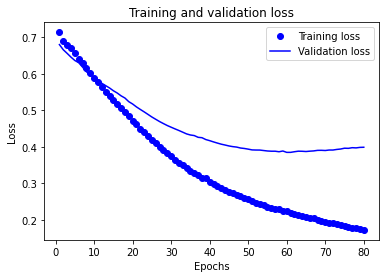

In [20]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# “bo”代表 "蓝点"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b代表“蓝色实线”
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

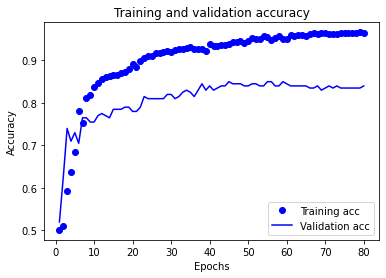

In [21]:
plt.clf()   # 清除数字

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()